In [99]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import os
from PIL import Image
import scipy
from scipy import misc
import cv2
import matplotlib.animation as animation
%matplotlib inline

The grid2grid function takes the calculated coordinate system and returns the transformed x,y

In [116]:
def grid2grid(x,y,x_dis, y_dis):
    return (int(np.floor(x+x_dis/100.)), int(np.floor(y+y_dis/100.))) #distance divided by 100m per pixel

Random generated velocity and image to test whether this algorithm works

In [101]:
V = np.zeros((1000,1000,2))
V[:,:400,0]=2
V[:,400:420,0] = 4
V[:,420:450,0] = 6
V[:,450:470,0] = 8
V[:,470:500,0] = 10
V[:,500:,0] = 12

V[:400,:,1] = -2
V[400:420,:,1] = -4
V[420:450,:,1] = -6
V[450:470,:,1] = -8
V[470:500,:,1] = -10
V[500:,:,1] = -12

curr_img = np.zeros((1000,1000))
curr_img[400:500, 400:500] = 10

## Numerical Solutions

### Advection
To solve for the first order advection equation, numerical solutions are taken to adaptively calculate the image for the next time step and then transform the grid into predicted images
$$
    I_{x,y}^{t+1} = I_{x,y}^t-\frac{U*dt}{dx}(I_{x,y}^t-I_{x-dx,y}^{t})- \frac{V*dt}{dy}(I_{x,y}^t-I_{x,{y-dy}}^t)
$$

In [119]:
def ADE_solver(curr_img, V , dt, nt):
    U = V[:,:,0]
    V = V[:,:,1]
    pred=[]
    In = curr_img.copy()
    for t in range(0,dt*nt, dt):
        pred_img = np.zeros((1000,1000))
        In[1:,1:] = curr_img[1:,1:] -U[1:,1:]*dt/100.*(curr_img[1:,1:]-curr_img[1:,0:-1]) -\
                    V[1:,1:]*dt/100.*(curr_img[1:,1:]-curr_img[0:-1,1:])
        x,y = np.where(In!=0)
        for (m,n) in zip(x,y):
            d_x, d_y = U[m,n]*dt, V[m,n]*dt
#            new_mat = diffusion(nx,ny,dt,D)*In[m,n]
            (trans_i, trans_j) = grid2grid(m,n,d_y,d_x)
            if 0<=trans_i<=999 and 0<=trans_j<=999: 
#                pred_img[trans_i-int(nx/2):trans_i+int(nx/2), trans_j-int(nx/2):trans_j+int(nx/2)] += new_mat
                pred_img[trans_i, trans_j] = In[m,n]
        curr_img=pred_img
        if t%60==0:
#            x,y = np.where(In!=0)
#            for (m,n) in zip(x,y):
#                d_x, d_y = U[m,n]*t, V[m,n]*t
#                new_mat = diffusion(nx,ny,dt,D)*In[m,n]
#                (trans_i, trans_j) = grid2grid(m,n,d_y,d_x)
#                if 0<=trans_i<=999 and 0<=trans_j<=999: 
#                    pred_img[trans_i-int(nx/2):trans_i+int(nx/2), trans_j-int(nx/2):trans_j+int(nx/2)] += new_mat
            pred_img[pred_img<0.5] = 0
            pred_img[pred_img>=0.5] = 1
            scipy.misc.imsave(f'D:/Radar Projects/lizhi/for LiZhi/WindField/ADE-{t}.png', pred_img)
            print(int(t/60),' mins processed')
            pred.append(pred_img)
    return pred


pred = ADE_solver(curr_img,V,5,360)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


0  mins processed
1  mins processed
2  mins processed
3  mins processed
4  mins processed
5  mins processed
6  mins processed
7  mins processed
8  mins processed
9  mins processed
10  mins processed
11  mins processed
12  mins processed
13  mins processed
14  mins processed
15  mins processed
16  mins processed
17  mins processed
18  mins processed
19  mins processed
20  mins processed
21  mins processed
22  mins processed
23  mins processed
24  mins processed
25  mins processed
26  mins processed
27  mins processed
28  mins processed
29  mins processed


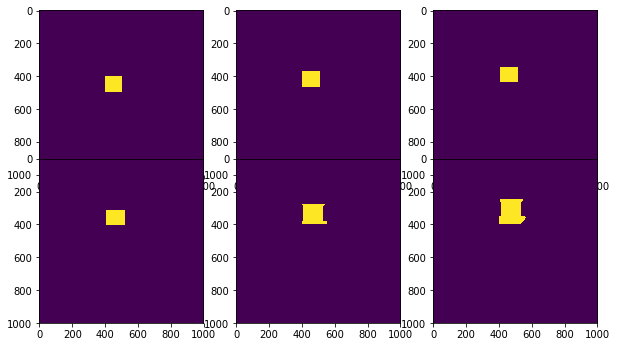

In [112]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(231)
plt.imshow(pred[0])
fig.add_subplot(232)
plt.imshow(pred[1])
fig.add_subplot(233)
plt.imshow(pred[2])
fig.add_subplot(131)
plt.imshow(pred[3])
fig.add_subplot(132)
plt.imshow(pred[4])
fig.add_subplot(133)
plt.imshow(pred[5])

### Advection + Diffusion

The first oder Advection equation is not able to fill the gaps e.g. some pixels run faster than others, then gaps will be created. The other way is to add second order term - diffusion. One simple way of taking this sparse distribution into account is by Gaussian filter. In each pixel, the additional Gaussian diffusion term will be added. This should be calibrated because it can not be realistic high as it will cause merge, and if it is low, it would not cover the gaps. Of course, it depends on velocity field.

$$
T(x,y,t)=\frac{1}{4\pi*dt}exp(\frac{-(x-x_0)^2}{4Dt_0}+\frac{-(y-y_0)^2}{4Dt_0})
$$

$$
    I_{x,y}^{t+1} = I_{x,y}^t-\frac{U*dt}{dx}(I_{x,y}^t-I_{x-dx,y}^{t})- \frac{V*dt}{dy}(I_{x,y}^t-I_{x,{y-dy}}^t)+\frac{D*dt}{dx^2}(I_{x+1,y}+I_{x-1,y}-2I_{x,y})+\frac{D*dt}{dy^2}(I_{x,y+1}+I_{x,y-1}-2I_{x,y})
$$

Stability Analysis:


In [61]:
from numba import jit
@jit(nopython=True)
def diffusion(nx,ny,dt,D):
    new_matrix = np.zeros((nx,ny), dtype=np.float64)
    X = np.arange(-nx*100,nx*100,nx+1)
    Y = np.arange(-ny*100,ny*100,ny+1)
    for i in range(nx):
        for j in range(ny):
            new_matrix[i,j] = np.exp(-X[i]**2/4/D/dt-Y[j]**2/4/D/dt)/1/dt/np.pi
    return new_matrix

In [109]:
def ADE_solver(curr_img, V ,D, nx, ny, dt, nt):
    U = V[:,:,0]
    V = V[:,:,1]
    pred=[]
    In = curr_img.copy()
    for t in range(0,dt*nt, dt):
        pred_img = np.zeros((1000,1000))
        In[2:,2:] = curr_img[2:,2:] -U[2:,2:]*dt/100./2*(curr_img[2:,2:]-curr_img[2:,0:-2]) -\
                    V[2:,2:]*dt/100./2*(curr_img[2:,2:]-curr_img[0:-2,2:])+D*dt/100**2*(curr_img[2:,2:]+curr_img[2:,:-2]-
                                                                                      2*curr_img[2:,1:-1])+\
                    D*dt/100**2*(curr_img[2:,2:]+curr_img[:-2,2:]-curr_img[1:-1,2:])
        x,y = np.where(In!=0)
        for (m,n) in zip(x,y):
            d_x, d_y = U[m,n]*dt, V[m,n]*dt
#            new_mat = diffusion(nx,ny,dt,D)*In[m,n]
            (trans_i, trans_j) = grid2grid(m,n,d_y,d_x)
            if 0<=trans_i<=999 and 0<=trans_j<=999: 
#                pred_img[trans_i-int(nx/2):trans_i+int(nx/2), trans_j-int(nx/2):trans_j+int(nx/2)] += new_mat
                pred_img[trans_i, trans_j] = In[m,n]
        curr_img=pred_img
        if t%60==0:
#            x,y = np.where(In!=0)
#            for (m,n) in zip(x,y):
#                d_x, d_y = U[m,n]*t, V[m,n]*t
#                new_mat = diffusion(nx,ny,dt,D)*In[m,n]
#                (trans_i, trans_j) = grid2grid(m,n,d_y,d_x)
#                if 0<=trans_i<=999 and 0<=trans_j<=999: 
#                    pred_img[trans_i-int(nx/2):trans_i+int(nx/2), trans_j-int(nx/2):trans_j+int(nx/2)] += new_mat
            pred_img[pred_img<0.5] = 0
            pred_img[pred_img>=0.5] = 1
            scipy.misc.imsave(f'D:/Radar Projects/lizhi/for LiZhi/WindField/ADE-diff-{t}.png', pred_img)
            print(int(t/60),' mins processed')
            pred.append(pred_img)
    return pred


pred = ADE_solver(curr_img,V,0,100,100,5,360)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


0  mins processed
1  mins processed
2  mins processed
3  mins processed
4  mins processed
5  mins processed
6  mins processed


KeyboardInterrupt: 

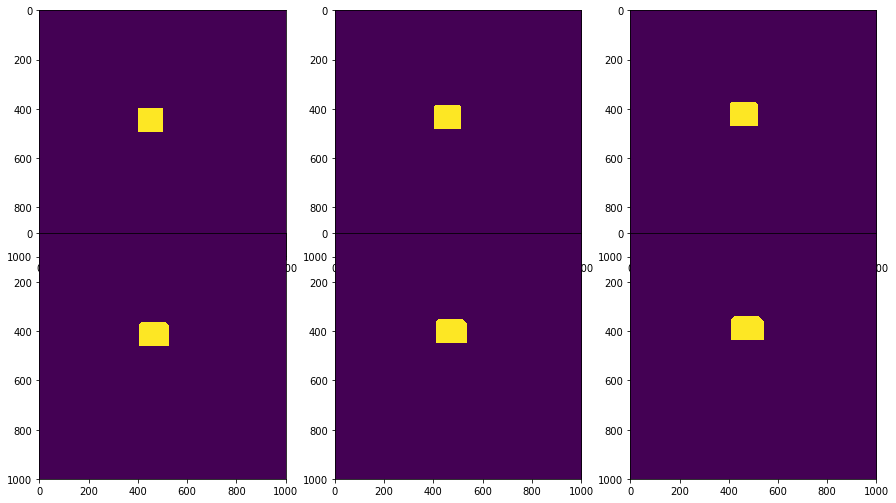

In [107]:
fig = plt.figure(figsize=(15,15))
fig.add_subplot(231)
plt.imshow(pred[0])
fig.add_subplot(232)
plt.imshow(pred[1])
fig.add_subplot(233)
plt.imshow(pred[2])
fig.add_subplot(131)
plt.imshow(pred[3])
fig.add_subplot(132)
plt.imshow(pred[4])
fig.add_subplot(133)
plt.imshow(pred[5])

## Analytical Solution

If the dispersion term can be simulated as Gaussian distribution, the analytical solution of the particle movement can be derived from that. The equations described as below:

$$
I(x,y,t) = \frac{I_{total}}{\sqrt{4\pi Dt}}exp(-\frac{(x-ut)^2+(y-vt)^2}{4Dt})
$$

In this way, the numerical diffusion can be mitigated

In [132]:
@jit(nopython=True)
def fast_iter(m,n,D,t, grid=1):
    X = np.arange(-100*grid,100*grid+100,100)
    Y = np.arange(-100*grid,100*grid+100,100)
    for i in range(grid*2):
        for j in range(grid*2):
            unit_I = 1/(4*np.pi*D*t)*np.exp((X[i]**2+Y[j]**2)/4/D/t)
    return unit_I

In [133]:
def ANA(curr_img, V, D,t,n=3):
    U = V[:,:,0]
    V = V[:,:,1]
    x,y = np.where(curr_img!=0)
    next_img = curr_img.copy()
    for m,n in zip(x,y):
        d_x = U[m,n]*t
        d_y = V[m,n]*t
        new_mat = np.zeros((n,n))
        new_mat = fast_iter(m,n,D,t)
        (trans_i, trans_j) = grid2grid(m,n,d_y,d_x)
        next_img[int(trans_i-n/2):int(trans_i+n/2+1), int(trans_j-n/2):int(trans_j+n/2+1)] += new_mat
    return next_img

In [134]:
for t in range(5,1800,5):
    pred_img = ANA(curr_img, V, 0.1, t)
    if t%60==0:
        pred_img[pred_img<0.5] = 0
        pred_img[pred_img>=0.5] = 1
        scipy.misc.imsave(f'D:/Radar Projects/lizhi/for LiZhi/WindField/ADE-ana-{t}.png', pred_img)
        print(int(t/60),' mins processed')

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  


1  mins processed
2  mins processed
3  mins processed
4  mins processed


KeyboardInterrupt: 